In [82]:
from statlib.simple_distribs import Cauchy, Pareto
from statlib.rand.basic_rand import BasicRand
from statlib.rand.engine import JLKiss64RandEngine
from matplotlib import pyplot as plt
import numpy as np

### Создадим генератор случайной величины

In [83]:
gen = BasicRand(JLKiss64RandEngine())

par = Cauchy(gen)

### Проверим гипотезу равномерности генератора

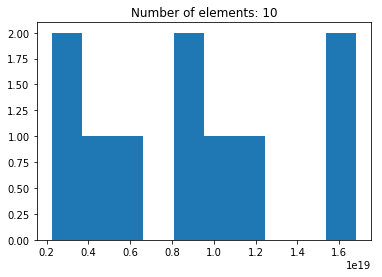

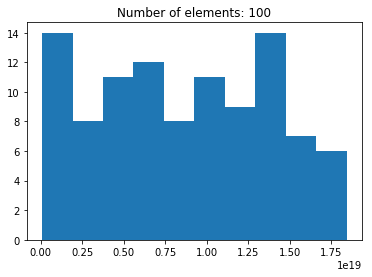

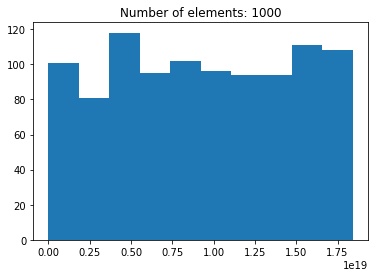

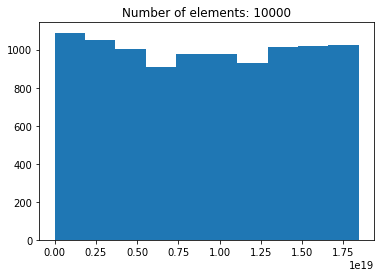

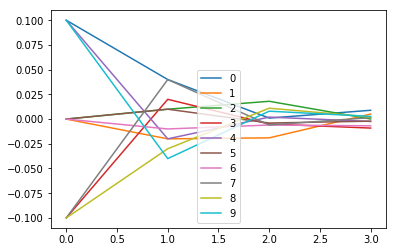

In [121]:
def test_uniformity(gen, iterations):
    vals = []
    for n in iterations:
        z = [gen.next() for _ in range(n)]
        vals.append(plt.hist(z)[0] / n)
        vals[-1] -= 1 / len(vals[-1])
        plt.title('Number of elements: {0}'.format(n))
        plt.show()
    
    # for each column plot differense with 1 / k
    vals = np.array(vals)
    nbins = len(vals[0])
    for i in range(nbins):
        plt.plot(vals[:, i], label=str(i))
    
    plt.legend()
    plt.show()
    
test_uniformity(gen, [10, 100, 1000, 10000])

### Проверим независимость

In [128]:
def test_independence(gen, iterations):
    r = []
    for n in iterations:
        s = n // 3
        z = np.array([gen.next() for _ in range(n)])
        mx = sum(z) / float(n)
        dx = sum((z - mx) ** 2) / float(n)

        
        if n == 10:
            for i in range(n - s):
                print(z[i], z[i + s])
            
        mxy = sum(z[i] * z[i + s] for i in range(n - s)) / float(n - s)
        r.append((mxy - mx * mx) / dx)
    print('Значения коэффициента корреляции:')
    print('\n'.join(["{:.5}".format(c) for c in r]))
    
test_independence(gen, [10, 100, 1000, 10000])

1.843946428089329e+17 1.3135339386423527e+19
7.751620538487231e+18 6.023661398594295e+18
8.990827421886202e+18 7.945209342346425e+18
1.3135339386423527e+19 4.412861663249934e+18
6.023661398594295e+18 1.4217879821021032e+19
7.945209342346425e+18 2.113790686134338e+18
4.412861663249934e+18 7.383984394164616e+18
Значения коэффициента корреляции:
-0.4212
0.2253
-0.031174
0.0058079


#### Начальные параметры для гистограмм

In [84]:
def get_bins_count(n):
    return int(np.sqrt(n))


n = 100000
segments = get_bins_count(n)

### Равноинтервальная гистограмма

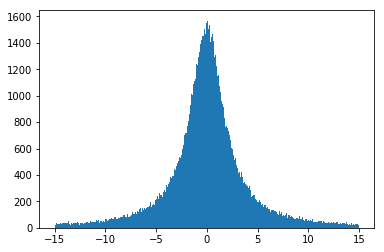

In [85]:
res = []
ranges = (-15, 15)
x0 = 0
gamma = 2

for _ in range(n):
    res.append(par.next(x0, gamma))

x_var_f = [x for x in x_var if x >= ranges[0] and x <= ranges[1]]
vals, bins, patches = plt.hist(res, bins=segments, range=ranges)

In [86]:
x_var = sorted(res)
counts = {}
for x in x_var:
    counts[x] = counts.get(x, 0) + 1
    
F = [0]
for i in range(len(x_var) - 1):
    F.append(F[i] + counts[x_var[i]] / n)

def distr_fun(x):
    for i in range(1, len(x_var)):
        if x_var[i - 1] <= x < x_var[i]:
            return F[i - 1]
    return 1

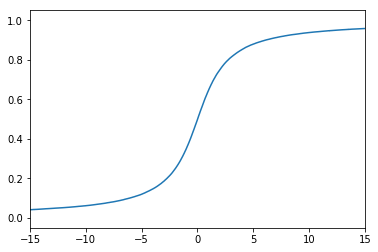

In [87]:
plt.xlim(ranges)
plt.step(sorted(res), F)

### Равновероятностная гистограмма

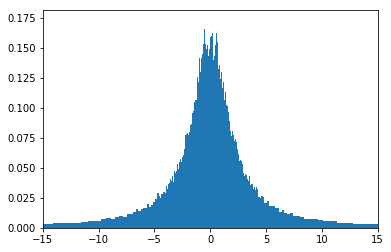

In [88]:
borders_eq = [x_var[0]] + [(x_var[i] + x_var[i + 1]) / 2 for i in range(n // segments - 1, n - 1, n // segments)] + [x_var[-1]]

plt.xlim(ranges)
vals_int, bins_int, patches_int = plt.hist(x_var, bins=borders_eq, density=True)

### Точечная оценка медианы

In [89]:
def find_median(bins, vals):
    med_amount = sum(vals) / 2
    h = bins[1] - bins[0]
    cur_sum = 0
    i = 0
    while cur_sum < med_amount:
        cur_sum += vals[i]
        i += 1

    return bins[i] + h * (med_amount - cur_sum + vals[i]) / vals[i]

med_p = find_median(bins, vals)
print(med_p)

0.10061398713150396


### Точечная оценка моды

In [90]:
def find_mode(bins, vals):
    mode_pos = 0
    max_val = 0
    h = bins[1] - bins[0]
    
    for i, val in enumerate(vals):
        if val > max_val:
            max_val = val
            mode_pos = i
   
    prev_pos = i - 1 if i - 1 >= 0 else 0
    next_pos = i + 1 if i + 1 < len(vals) else 0
    
    return bins[mode_pos] + h * (vals[mode_pos] - vals[prev_pos]) / (vals[mode_pos] - vals[prev_pos] + vals[mode_pos] - vals[next_pos])

mod_p = find_mode(bins, vals)
print(mod_p)

0.047376063397788236


In [91]:
def get_median_confidense(x_var, a=0.05):
    n = len(x_var)
    if a == 0.1:
        k = 0.5 * (n - 1.64 * np.sqrt(n) - 1)
    if a == 0.05:
        k = 0.5 * (n - 1.96 * np.sqrt(n) - 1)
    if a == 0.01:
        k = 0.5 * (n - 2.58 * np.sqrt(n) - 1)
    
    k = int(k)
    print(k, n - k + 1)
    return x_var[k], x_var[n - k + 1]

get_median_confidense(x_var_f)

45511 46107


(-0.017434562319814745, 0.02098221933163465)

### Проверим критерий согласия Пирсона

In [92]:
import math

# distribution function
def get_F(x0, gamma):
    def F(x):
        return 1 / math.pi * np.arctan((x - x0) / gamma) + 1 / 2
    
    return F

def pearson_chi(bins, vals, F):
    n = sum(vals)
    chi = 0
    for i in range(len(bins) - 1):
        l = bins[i]
        r = bins[i + 1]
        pi_s = F(r) - F(l)
        pi = vals[i] / n
        chi += (pi - pi_s)**2 / pi
    
    return chi * len(bins)


from scipy.stats import chi2

chi_sqr = pearson_chi(bins, vals, get_F(x0, gamma))
table_pearson = chi2.ppf(0.05, len(bins))
print('Experimental chi square: {cs}, Table chi square: {ts}'.format(cs=chi_sqr, ts=table_pearson))
if chi_sqr < table_pearson:
    print('Good')

Experimental chi square: 3.041767629922656, Table chi square: 276.7514409808032
Good
